# Linear Regression Modeling of King County Real Estate Sale Prices
<b>Authors:</b> Aisha Baitemirova-Othman, Angela Kim, Steven Addison, Wahaj Dar
\
<b>Instructor:</b> David Elliott
----

## Overview
This project analyzes residential real estate sales in King County, Washington, and uses the data to create a model that predicts price based on the parameters given.

## Business Problem
Windermere Real Estate, based in Seattle, Washington, wants to better serve home buyers by being able to accurately present a price point using features of a house (ie. number of bedrooms) that buyers are looking for.

## Data Understanding
This dataset contains information about residential real estate sales in King County between May 2014 - May 2015. It includes details such as number of bedrooms and bathrooms, square footage of the home, and various features regarding location.

## Data Preparation

In [2]:
#Importing all the modules and tools we will use
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

!pip install geopy
import geopy
from geopy import distance
import plotly.express as px

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE

> Here we import our data and skim the first five rows to get a general idea of what the dataframe looks like. We also get an initial look at missing values and datatypes that need to be converted.

In [3]:
#Importing the data frame and taking a look at what we are working with
df = pd.read_csv('data/kc_house_data.csv')
display(df.head())
display(df.info())

id        date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014  221900.0         3       1.00         1180   
1  6414100192   12/9/2014  538000.0         3       2.25         2570   
2  5631500400   2/25/2015  180000.0         2       1.00          770   
3  2487200875   12/9/2014  604000.0         4       3.00         1960   
4  1954400510   2/18/2015  510000.0         3       2.00         1680   

   sqft_lot  floors waterfront  view  ...          grade sqft_above  \
0      5650     1.0        NaN  NONE  ...      7 Average       1180   
1      7242     2.0         NO  NONE  ...      7 Average       2170   
2     10000     1.0         NO  NONE  ...  6 Low Average        770   
3      5000     1.0         NO  NONE  ...      7 Average       1050   
4      8080     1.0         NO  NONE  ...         8 Good       1680   

   sqft_basement yr_built  yr_renovated  zipcode      lat     long  \
0            0.0     1955           0.0    98178  47.5112 -122.257   
1          400.0     1951        1991.0    98125  47.7210 -122.319   
2            0.0     1933           NaN    98028  47.7379 -122.233   
3          910.0     1965           0.0    98136  47.5208 -122.393   
4            0.0     1987           0.0    98074  47.6168 -122.045   

   sqft_living15  sqft_lot15  
0           1340        5650  
1           1690        7639  
2           2720        8062  
3           1360        5000  
4           1800        7503  

[5 rows x 21 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

None

> Cleaning & preparing the data.

In [4]:
# Drop the 'id' and 'date' columns
# Fill in missing data
# Convert all object datatype columns to numeric

df['yr_renovated'] = df['yr_renovated'].fillna(0)
df['waterfront'] = df['waterfront'].fillna('NO')
df['waterfront'] = df['waterfront'].str.replace('NO', '0')
df['waterfront'] = df['waterfront'].str.replace('YES', '1')
df['waterfront'] = pd.to_numeric(df['waterfront'])
df['view'] = df['view'].fillna('NONE')
df['grade'] = df['grade'].str.replace('7 Average', '7')
df['grade'] = df['grade'].str.replace('8 Good', '8')
df['grade'] = df['grade'].str.replace('9 Better', '9')
df['grade'] = df['grade'].str.replace('6 Low Average', '6')
df['grade'] = df['grade'].str.replace('10 Very Good', '10')
df['grade'] = df['grade'].str.replace('11 Excellent', '11')
df['grade'] = df['grade'].str.replace('5 Fair', '5')
df['grade'] = df['grade'].str.replace('12 Luxury', '12')
df['grade'] = df['grade'].str.replace('4 Low', '4')
df['grade'] = df['grade'].str.replace('13 Mansion', '13')
df['grade'] = df['grade'].str.replace('3 Poor', '3')
df['grade'] = pd.to_numeric(df['grade'])
if [df[df['sqft_basement'] == '?']]:
    df['sqft_basement'] = df['sqft_living'] - df['sqft_above']
df['sqft_basement'] = pd.to_numeric(df['sqft_basement'])
df['bedrooms'].replace(33, 3, inplace=True)
df['date'] = pd.to_datetime(df['date'])
df['yr_sold'] = df['date'].dt.year
df['house_age'] = df['yr_sold'] - df['yr_built']
df.drop(labels=['id', 'date'], axis=1, inplace=True)

In [5]:
# One-hot encoding 'condition' and 'view' columns

condition = df[['condition']]
ohe = OneHotEncoder(categories="auto", sparse=False, handle_unknown="ignore")
ohe.fit(condition)
condition_enc = ohe.transform(condition)
condition_enc = pd.DataFrame(condition_enc,
                             columns=['cond_avg','cond_fair','cond_good','cond_poor','cond_verygood'],
                             index=df.index)
df.drop('condition', axis=1, inplace=True)
df = pd.concat([df, condition_enc], axis=1)

view = df[['view']]
ohe.fit(view)
view_enc = ohe.transform(view)
view_enc = pd.DataFrame(view_enc,
                        columns=['view_avg','view_excellent','view_fair','view_good','view_none'],
                        index=df.index)
df.drop('view', axis=1, inplace=True)
df = pd.concat([df, view_enc], axis=1)

In [6]:
# Create 'distance_from_bellevue' column

bellevue = (47.601, -122.2015)

def distancer(row):
    coords_1 = bellevue
    coords_2 = (row['lat'], row['long'])
    return geopy.distance.distance(coords_1, coords_2).miles

df['distance_from_bellevue'] = df.apply(distancer, axis=1)

# Plot distance map

distancemap = df[df['price'] <= 1000000] 
fig = px.scatter_mapbox(data_frame = distancemap, lat='lat', lon='long', color='price', color_continuous_scale='deep_r')
fig.update_geos(resolution=50)
fig.update_layout(mapbox_style="carto-darkmatter")

In [7]:
# Examine correlations

corr = df.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='mako', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

> 'sqft_living' has the highest correlation with 'price' at 0.70. We also see high multicollinearity.

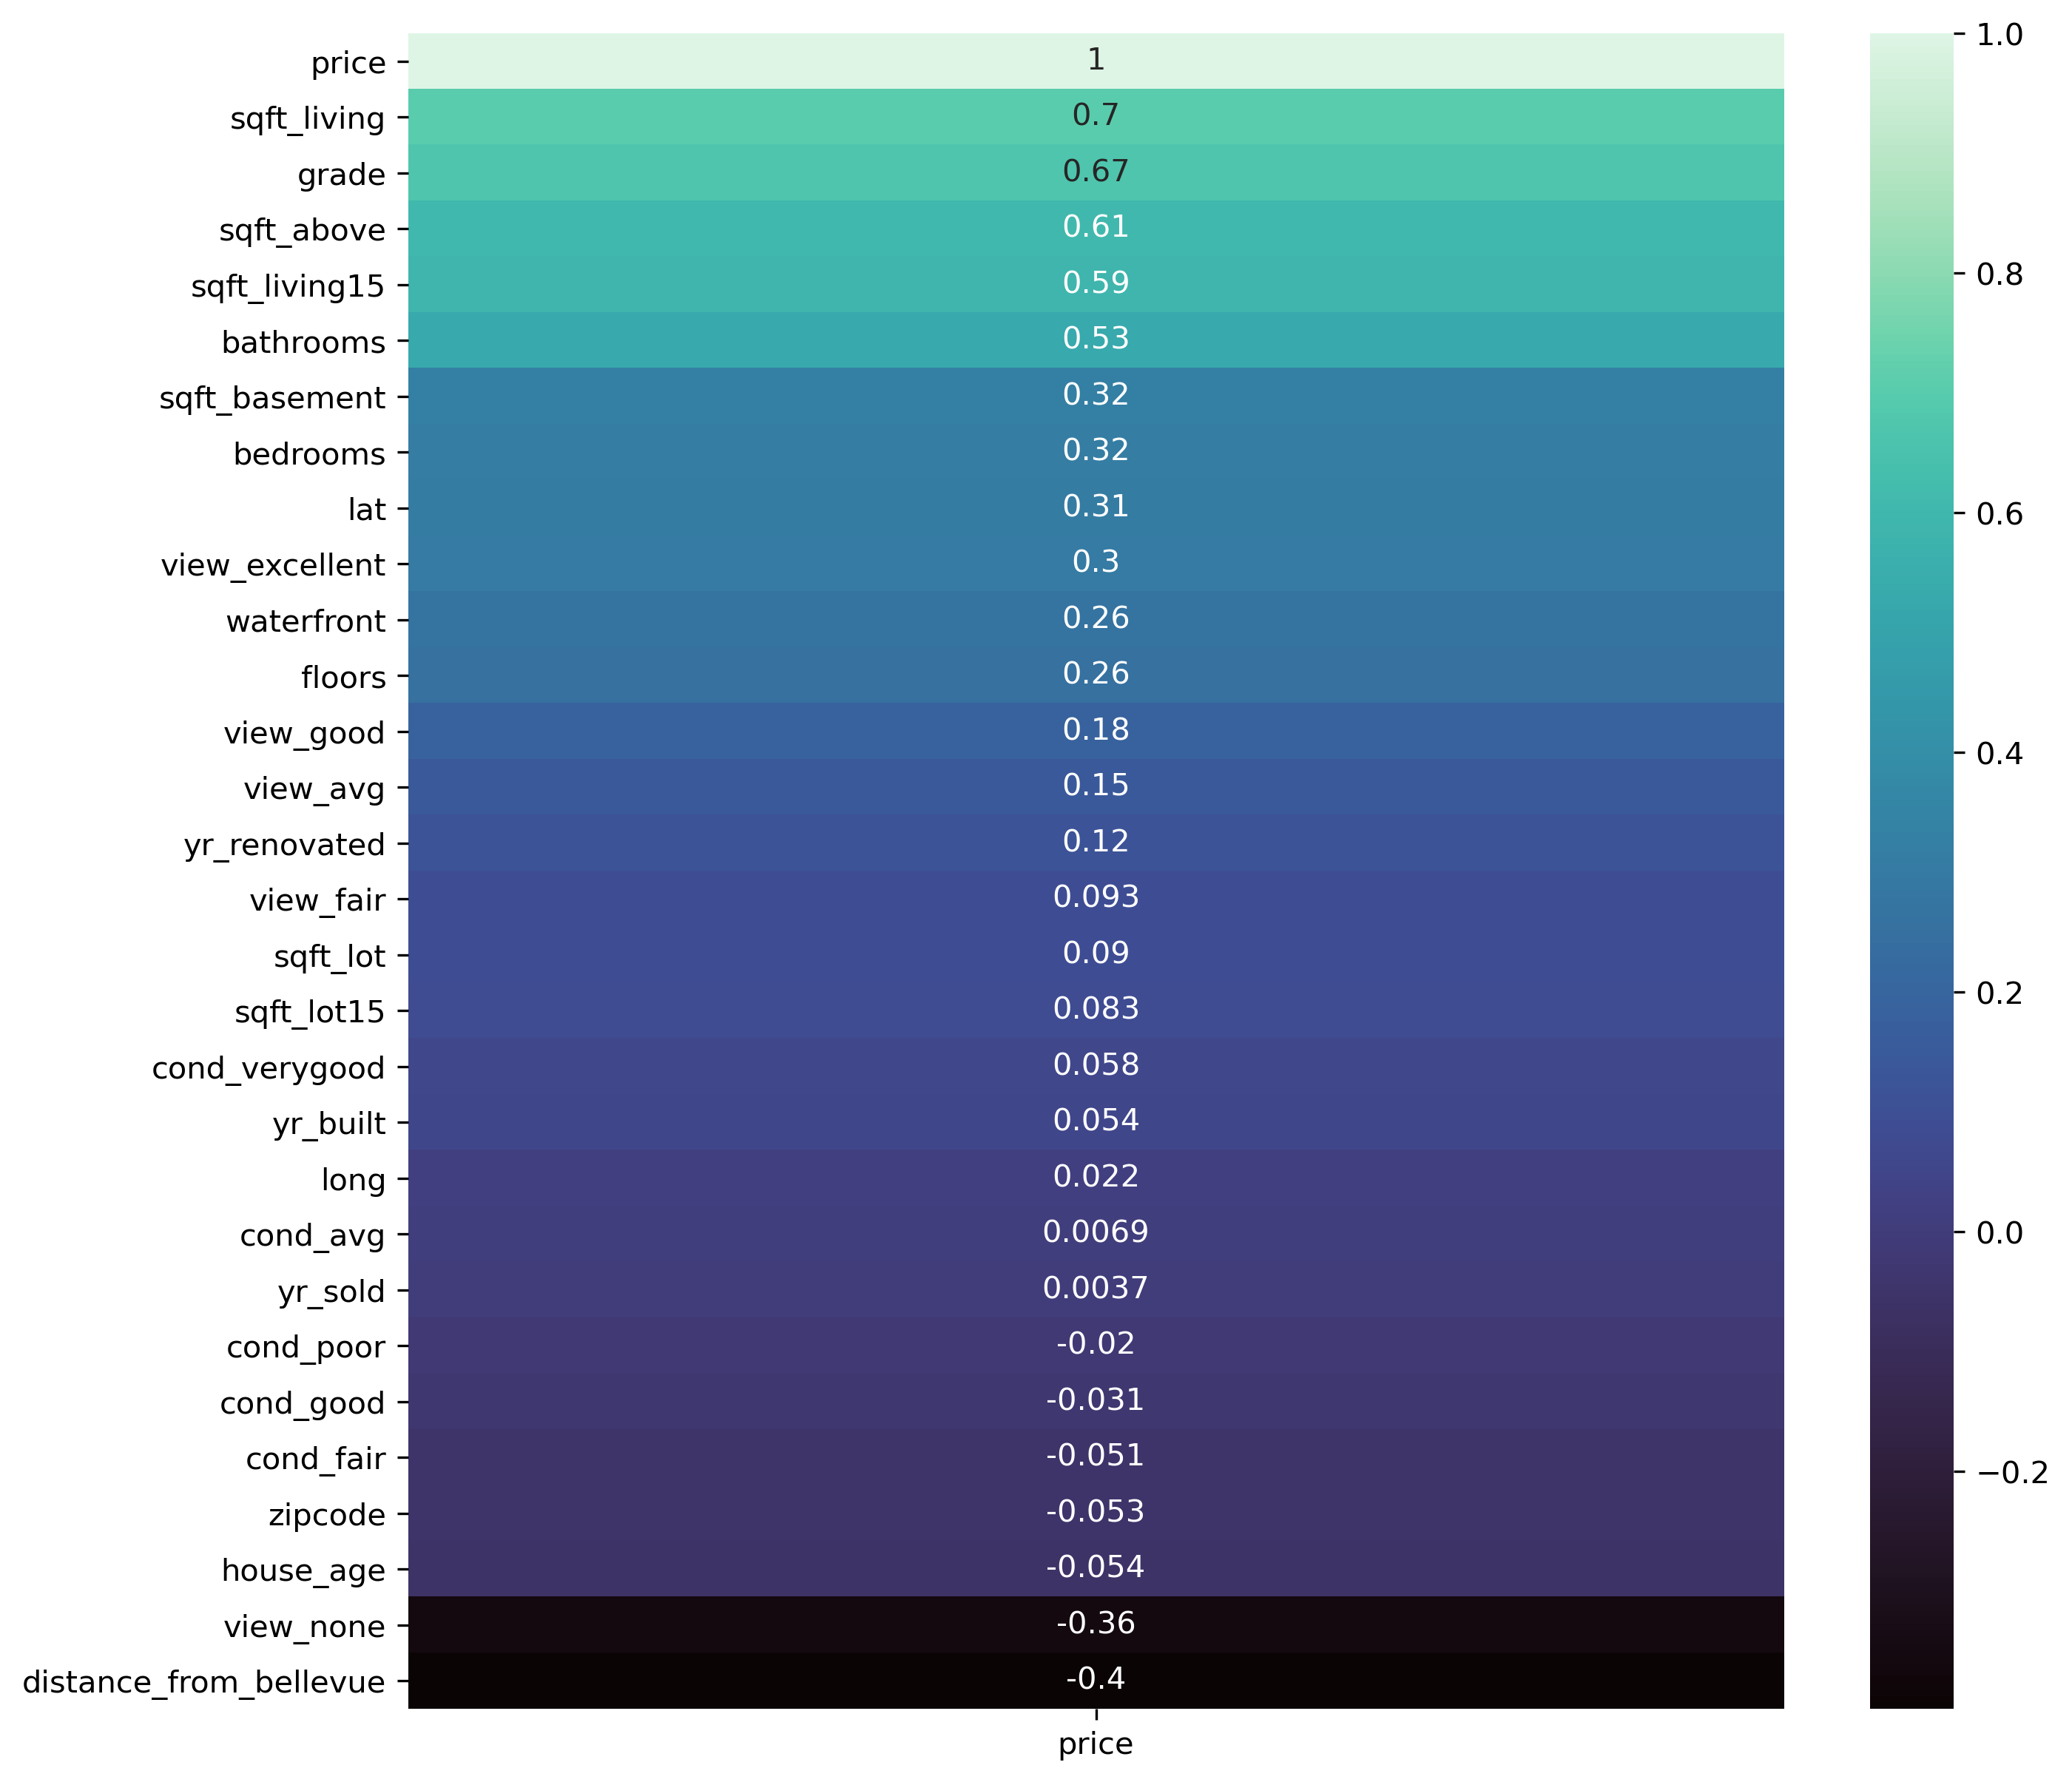

In [8]:
ix = df.corr().sort_values('price', ascending=False).index
df_sorted = df.loc[:, ix]

plt.figure(figsize=(10,10), dpi=300)
sns.heatmap(df_sorted.corr()[['price']],
            cmap="mako",
            annot=True);

In [9]:
#creating a more understandable heatmap to show during our presentation
heatmap = df[['price','sqft_living','grade','sqft_above','distance_from_bellevue','view_none','house_age','zipcode']]
heatmap

price  sqft_living  grade  sqft_above  distance_from_bellevue  \
0      221900.0         1180      7        1180                6.724913   
1      538000.0         2570      7        2170                9.940080   
2      180000.0          770      6         770                9.571487   
3      604000.0         1960      7        1050               10.530416   
4      510000.0         1680      8        1680                7.392620   
...         ...          ...    ...         ...                     ...   
21592  360000.0         1530      8        1530                9.572031   
21593  400000.0         2310      8        2310                9.760026   
21594  402101.0         1020      7        1020                4.578875   
21595  400000.0         1600      8        1600                7.712755   
21596  325000.0         1020      7        1020                4.580999   

       view_none  house_age  zipcode  
0            1.0         59    98178  
1            1.0         63    98125  
2            1.0         82    98028  
3            1.0         49    98136  
4            1.0         28    98074  
...          ...        ...      ...  
21592        1.0          5    98103  
21593        1.0          1    98146  
21594        1.0          5    98144  
21595        1.0         11    98027  
21596        1.0          6    98144  

[21597 rows x 8 columns]

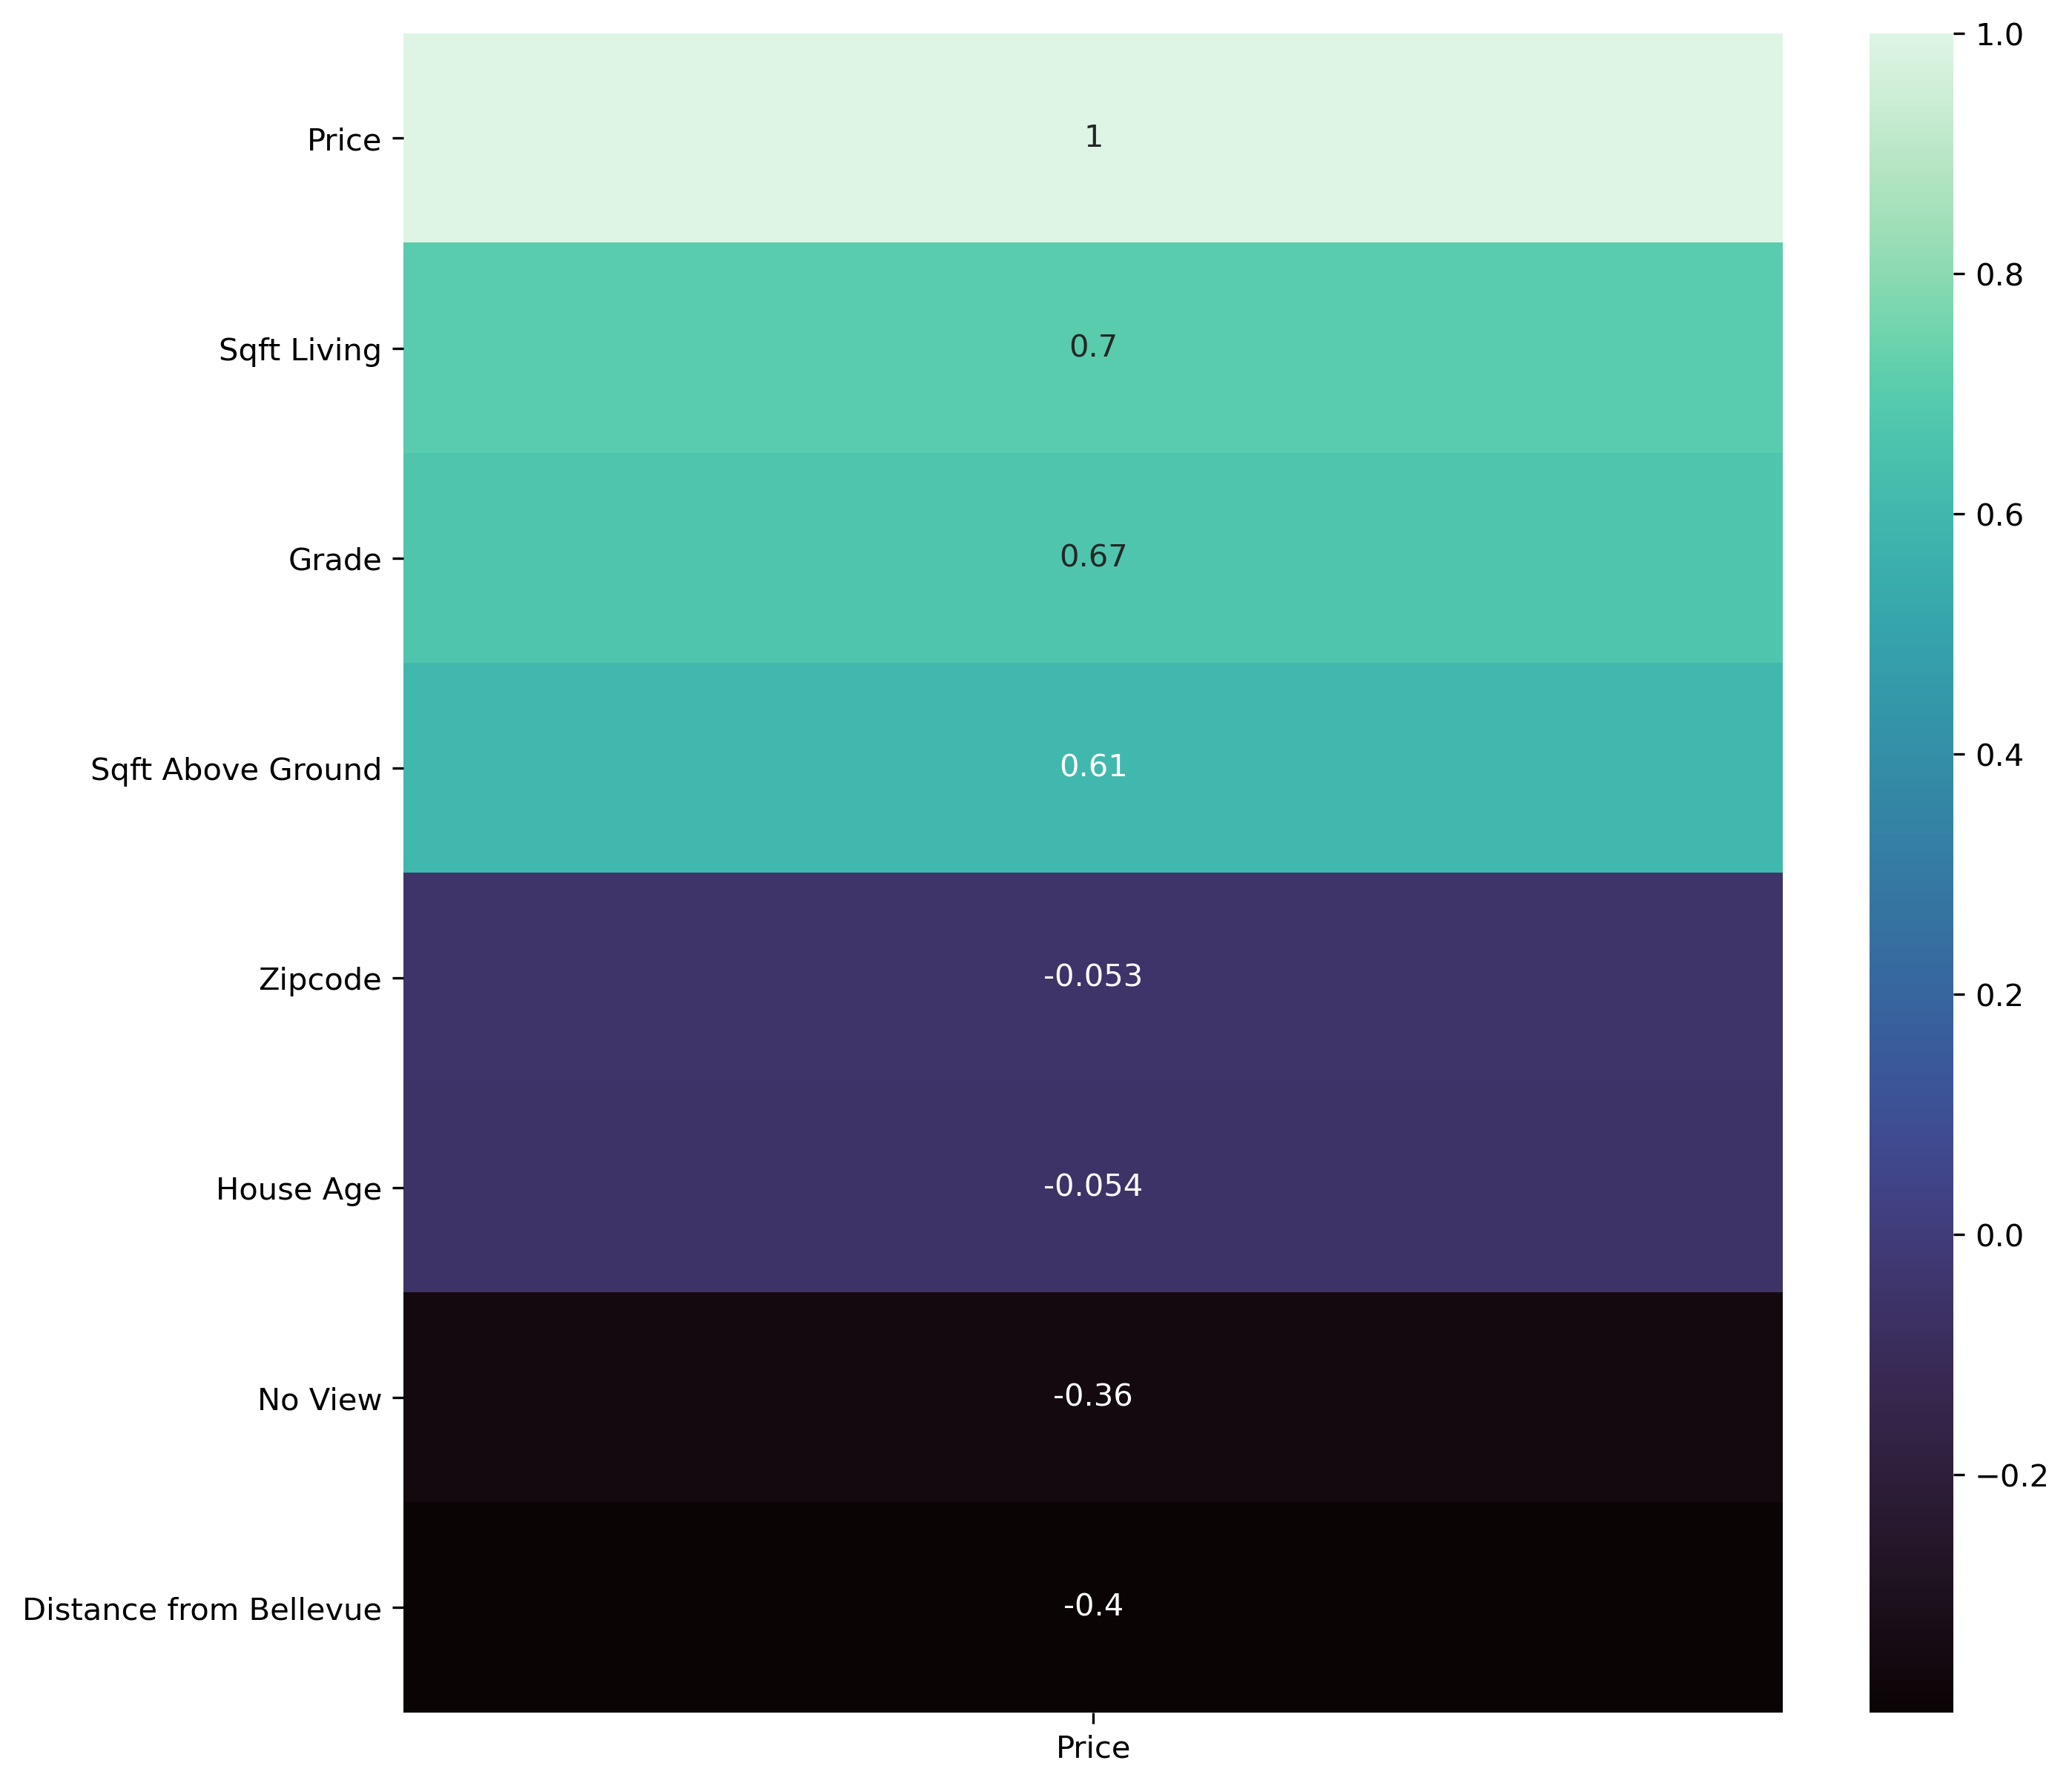

In [10]:
# heatmap for presentation
ix2 = heatmap.corr().sort_values('price', ascending=False).index
df_sorted2 = df.loc[:, ix2]

plt.figure(figsize=(10,10), dpi=300)
sns.heatmap(df_sorted2.corr()[['price']],
            xticklabels=['Price'],
            yticklabels=['Price', 'Sqft Living', 'Grade', 'Sqft Above Ground',
                         'Zipcode', 'House Age', 'No View', 'Distance from Bellevue'],
            cmap="mako",
            annot=True)
plt.yticks(rotation=0);

In [ ]:
# Scatter matrix

scatter_columns = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
                   'floors', 'waterfront', 'grade', 'sqft_above', 'sqft_basement',
                   'yr_built', 'zipcode', 'lat', 'long', 'sqft_living15','sqft_lot15']

df_scatter = df[scatter_columns]

sns.pairplot(df_scatter, corner=True);

> Scatter matrix shows many non-normal distributions.

## Inferential Modeling

In [11]:
# Analyzing OLS results

outcome = 'price'
dfx = df.drop('price', axis=1)
predictors = '+'.join(dfx.columns)
formula = outcome + '~' + predictors
model = ols(formula=formula, data=df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     2270.
Date:                Fri, 19 Nov 2021   Prob (F-statistic):               0.00
Time:                        08:15:18   Log-Likelihood:            -2.9347e+05
No. Observations:               21597   AIC:                         5.870e+05
Df Residuals:                   21571   BIC:                         5.872e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept              -2.869e+07   4.53e+06     -6.328      0.000   -3.76e+07   -1.98e+07
bedrooms               -4.093e+04   1899.880    -21.544      0.000   -4.47e+04   -3.72e+04
bathrooms               4.038e+04   3139.238     12.864      0.000    3.42e+04    4.65e+04
sqft_living              111.4975      2.194     50.809      0.000     107.196     115.799
sqft_lot                   0.2136      0.046      4.639      0.000       0.123       0.304
floors                  2372.2405   3463.560      0.685      0.493   -4416.592    9161.073
waterfront              5.355e+05   1.96e+04     27.378      0.000    4.97e+05    5.74e+05
grade                   8.844e+04   2087.403     42.369      0.000    8.43e+04    9.25e+04
sqft_above                78.3972      2.171     36.109      0.000      74.142      82.653
sqft_basement             33.1232      2.548     13.001      0.000      28.129      38.117
yr_built                8639.5763    939.648      9.194      0.000    6797.797    1.05e+04
yr_renovated              24.9298      3.824      6.520      0.000      17.435      32.425
zipcode                 -507.6069     31.836    -15.944      0.000    -570.008    -445.206
lat                     3.072e+05   1.26e+04     24.379      0.000    2.83e+05    3.32e+05
long                   -1.492e+05   1.27e+04    -11.719      0.000   -1.74e+05   -1.24e+05
sqft_living15              8.8410      3.328      2.656      0.008       2.318      15.364
sqft_lot15                -0.1242      0.071     -1.759      0.079      -0.263       0.014
yr_sold                 1.954e+04   1877.232     10.410      0.000    1.59e+04    2.32e+04
house_age                1.09e+04    938.899     11.611      0.000    9061.481    1.27e+04
cond_avg               -5.748e+06   9.07e+05     -6.337      0.000   -7.53e+06   -3.97e+06
cond_fair              -5.746e+06   9.07e+05     -6.334      0.000   -7.52e+06   -3.97e+06
cond_good              -5.725e+06   9.07e+05     -6.314      0.000    -7.5e+06   -3.95e+06
cond_poor              -5.785e+06   9.07e+05     -6.376      0.000   -7.56e+06   -4.01e+06
cond_verygood          -5.686e+06   9.07e+05     -6.272      0.000   -7.46e+06   -3.91e+06
view_avg               -5.792e+06   9.07e+05     -6.387      0.000   -7.57e+06   -4.01e+06
view_excellent         -5.552e+06   9.07e+05     -6.121      0.000   -7.33e+06   -3.77e+06
view_fair              -5.765e+06   9.07e+05     -6.356      0.000   -7.54e+06   -3.99e+06
view_good              -5.714e+06   9.07e+05     -6.300      0.000   -7.49e+06   -3.94e+06
view_none              -5.867e+06   9.07e+05     -6.472      0.000   -7.64e+06   -4.09e+06
distance_from_bellevue -1.331e+04    328.984    -40.459      0.000    -1.4e+04   -1.27e+04
==============================================================================
O

> The p-values for 'floors' and 'sqft_lot15' are not statistically significant. JB is very high, indicating non-normal distributions. There is strong multicollinearity.

> Previously, we saw that 'price' and 'sqft_living' have the strongest correlation, but the scatter matrix reveals that they are not normally distributed.

In [12]:
# OLS between 'price' and 'sqft_living'
f = 'price~sqft_living'
model = ols(f, df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                 2.097e+04
Date:                Fri, 19 Nov 2021   Prob (F-statistic):               0.00
Time:                        08:15:20   Log-Likelihood:            -3.0006e+05
No. Observations:               21597   AIC:                         6.001e+05
Df Residuals:                   21595   BIC:                         6.001e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept   -4.399e+04   4410.023     -9.975      0.000   -5.26e+04   -3.53e+04
sqft_living   280.8630      1.939    144.819      0.000     277.062     284.664
==============================================================================
Omnibus:                    14801.942   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           542662.604
Skew:                           2.820   Prob(JB):                         0.00
Kurtosis:                      26.901   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

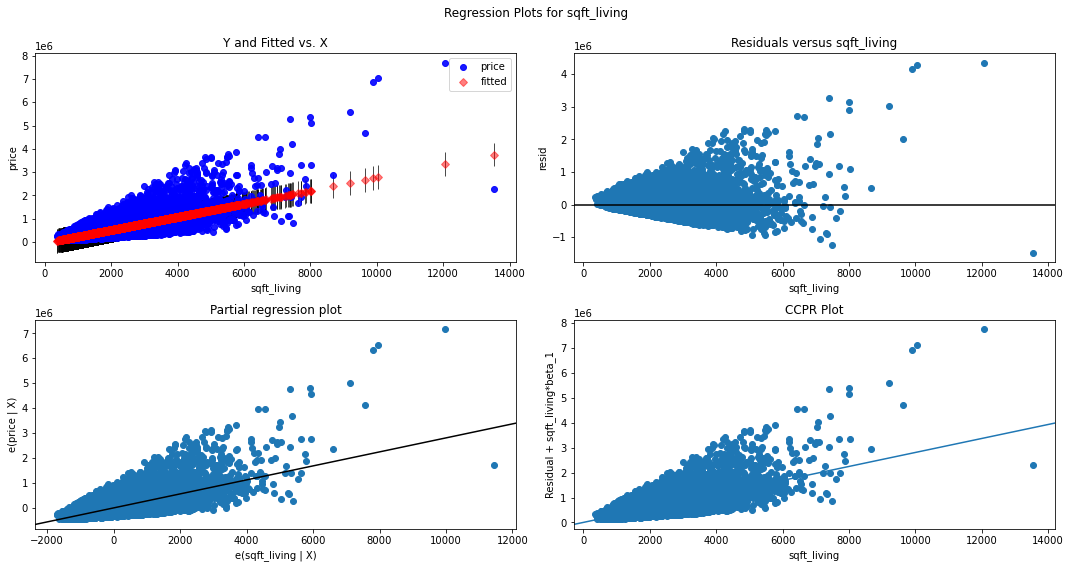

In [13]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, 'sqft_living', fig=fig);

> Plots show heteroscedasticity.

In [14]:
f = 'price~distance_from_bellevue'
model = ols(f, df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     4062.
Date:                Fri, 19 Nov 2021   Prob (F-statistic):               0.00
Time:                        08:15:26   Log-Likelihood:            -3.0553e+05
No. Observations:               21597   AIC:                         6.111e+05
Df Residuals:                   21595   BIC:                         6.111e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               8.254e+05   5026.642    164.200      0.000    8.16e+05    8.35e+05
distance_from_bellevue -2.677e+04    420.035    -63.734      0.000   -2.76e+04   -2.59e+04
==============================================================================
Omnibus:                    20006.141   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1572480.456
Skew:                           4.233   Prob(JB):                         0.00
Kurtosis:                      43.936   Cond. No.                         26.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

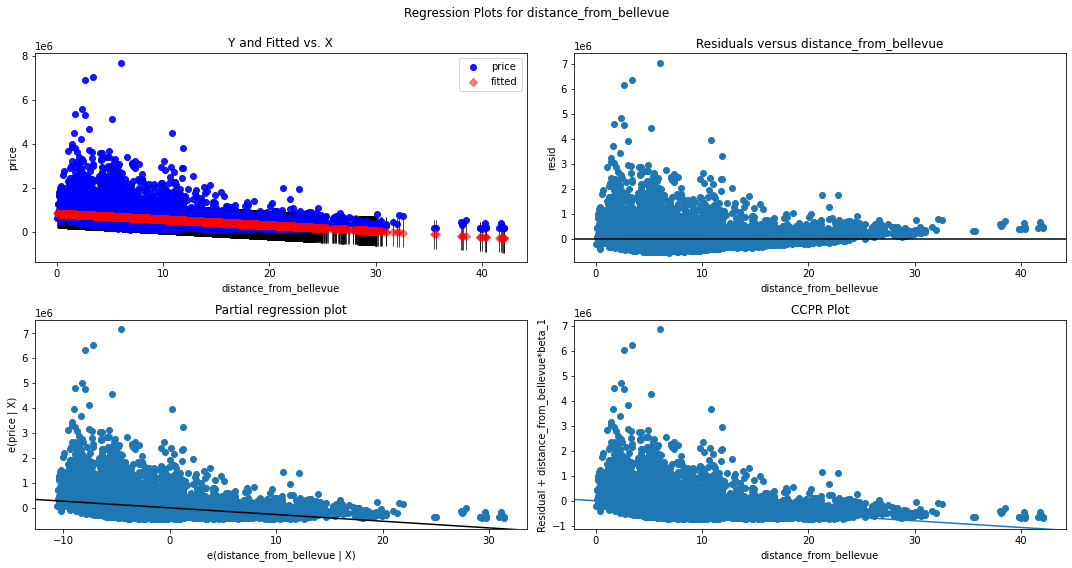

In [15]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, "distance_from_bellevue", fig=fig)
plt.show()

In [16]:
# Normalizing distribution using log transformation

df0 = df.copy()
df0['price_log'] = np.log(df0['price'])
df0['sqft_living_log'] = np.log(df0['sqft_living'])
df0 = df0.drop(['price', 'sqft_living'], axis=1)

# OLS between 'price_log' and 'sqft_living_log'

f = 'price_log~sqft_living_log'
model = ols(f, df0).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              price_log   R-squared:                       0.455
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                 1.805e+04
Date:                Fri, 19 Nov 2021   Prob (F-statistic):               0.00
Time:                        08:15:32   Log-Likelihood:                -10231.
No. Observations:               21597   AIC:                         2.047e+04
Df Residuals:                   21595   BIC:                         2.048e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           6.7234      0.047    142.612      0.000       6.631       6.816
sqft_living_log     0.8376      0.006    134.368      0.000       0.825       0.850
==============================================================================
Omnibus:                      123.577   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              114.096
Skew:                           0.143   Prob(JB):                     1.68e-25
Kurtosis:                       2.787   Cond. No.                         137.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

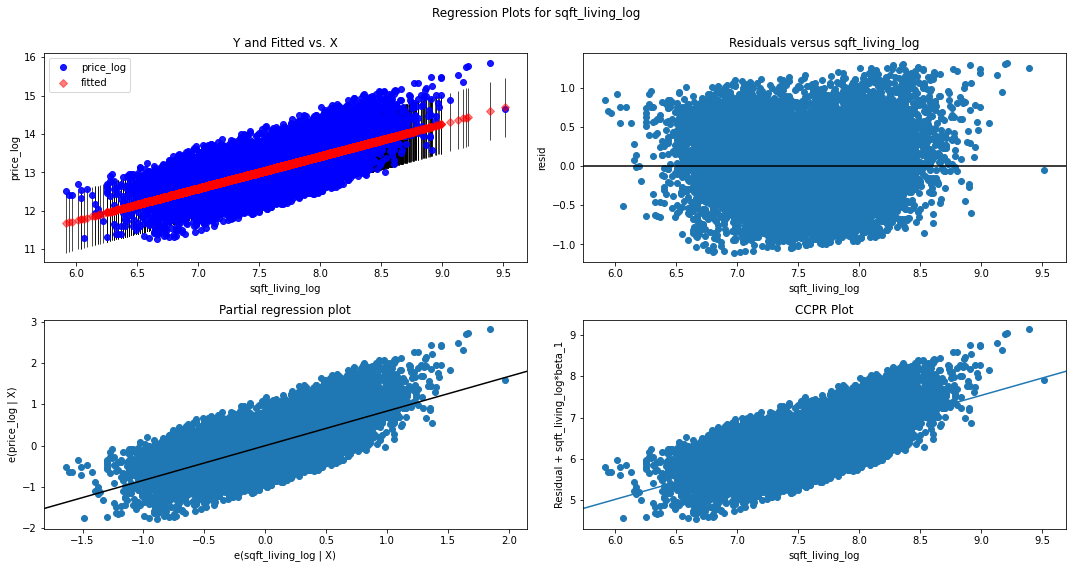

In [17]:
fig = plt.figure(figsize=(15,8))
fig = sm.graphics.plot_regress_exog(model, 'sqft_living_log', fig=fig);

> When 'price' and 'sqft_living' undergo log transformation, they are more normally distributed and more homoscedastic, making them better for modeling.

## Predictive Modeling

<b>Baseline Model & First Simple Linear Regression Model</b>

Baseline Train R²: 0.0
Baseline Test R²: -7.611977848931417e-06

Simple LR Train R²: 0.4559935622464675
Simple LR Test R²: 0.4533592790543598
Simple LR Train RMSE: 0.38932939001222455
Simple LR Test RMSE: 0.3863726040140355
Simple Condition Number: 136.8975981292544


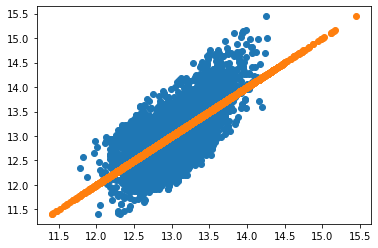

In [18]:
# df0 has original price & sqft_living removed, has price_log & sqft_living_log
X = df0[['sqft_living_log']]
y = df0[['price_log']]
X_train, X_test, y_train, y_test = train_test_split(X, y)

# baseline
baseline = DummyRegressor()
baseline.fit(X_train, y_train)
print('Baseline Train R\u00b2:', baseline.score(X_train, y_train))
print('Baseline Test R\u00b2:', baseline.score(X_test, y_test))
print()

# simple lr
lr = LinearRegression()
lr.fit(X_train, y_train)
y_hat_train = lr.predict(X_train)
y_hat_test = lr.predict(X_test)
train_rmse = mse(y_train, y_hat_train, squared=False)
test_rmse = mse(y_test, y_hat_test, squared=False)
condition_num = sm.OLS(y_train, sm.add_constant(X_train)).fit().condition_number
print('Simple LR Train R\u00b2:', lr.score(X_train, y_train))
print('Simple LR Test R\u00b2:', lr.score(X_test, y_test))
print('Simple LR Train RMSE:', train_rmse)
print('Simple LR Test RMSE:', test_rmse)
print('Simple Condition Number:',condition_num)
y_test_pred = lr.predict(X_test)
plt.scatter(y_test_pred, y_test)
plt.scatter(y_test, y_test);

<b>First Multiple Linear Regression Model</b>
\
Model with all untouched predictor variables.

LR1 Train R²: 0.7227415083845596
LR1 Test R²: 0.7280296563595856
LR1 Train RMSE: 191512.90263985636
LR1 Test RMSE: 197177.0082445334
LR1 Condition Number: 1.006084430986517e+16


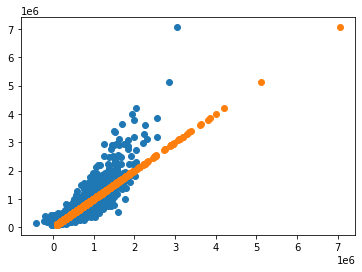

In [19]:
# df1 = original df
df1 = df.copy()
X1 = df1.drop(['price'], axis=1)
y1 = df1[['price']]
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1)
lr1 = LinearRegression()
lr1.fit(X1_train, y1_train)
y1_hat_train = lr1.predict(X1_train)
y1_hat_test = lr1.predict(X1_test)
train1_rmse = mse(y1_train, y1_hat_train, squared=False)
test1_rmse = mse(y1_test, y1_hat_test, squared=False)
condition_num1 = sm.OLS(y1_train, sm.add_constant(X1_train)).fit().condition_number
print('LR1 Train R\u00b2:', lr1.score(X1_train, y1_train))
print('LR1 Test R\u00b2:', lr1.score(X1_test, y1_test))
print('LR1 Train RMSE:', train1_rmse)
print('LR1 Test RMSE:', test1_rmse)
print('LR1 Condition Number:',condition_num1)
y1_test_pred = lr1.predict(X1_test)
plt.scatter(y1_test_pred, y1_test)
plt.scatter(y1_test, y1_test);

> There are outliers in our dataset affecting our model.

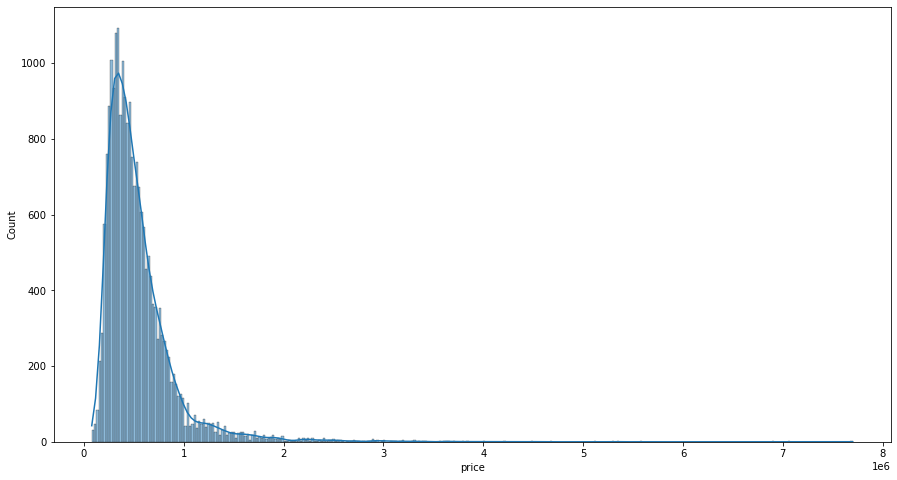

In [20]:
plt.figure(figsize=(15,8))
sns.histplot(df['price'], kde=True);

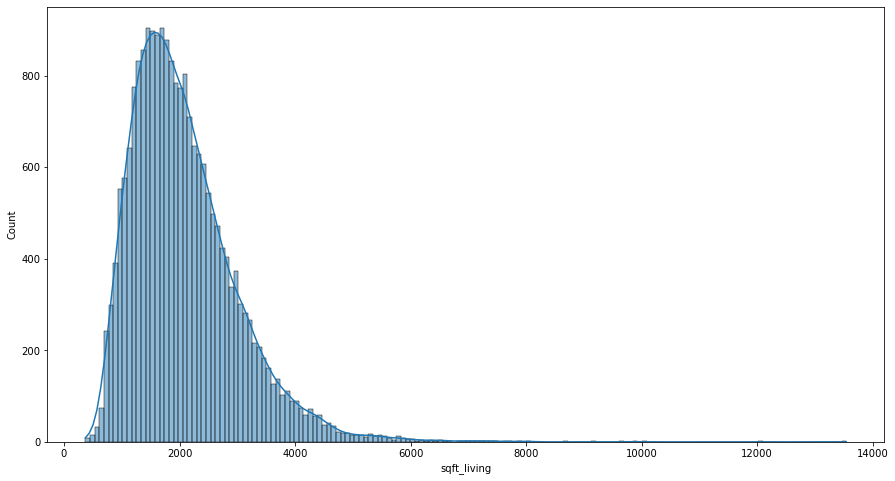

In [21]:
plt.figure(figsize=(15,8))
sns.histplot(df['sqft_living'], kde=True);

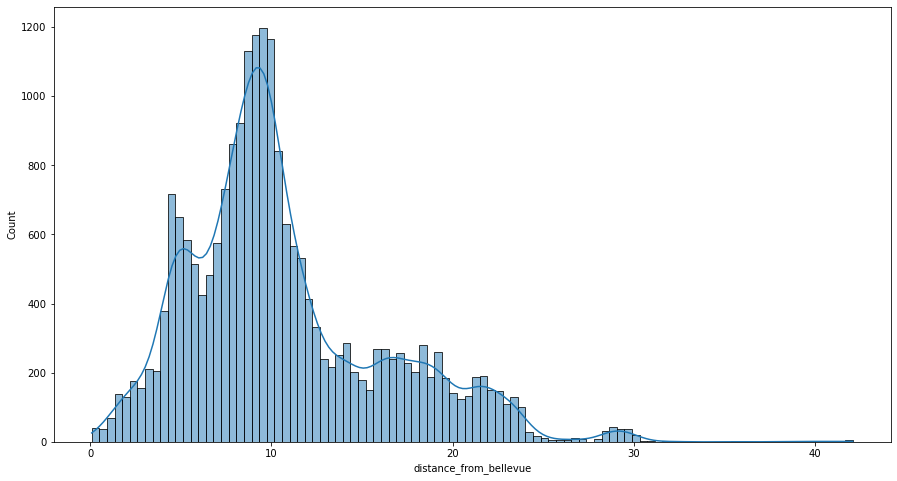

In [22]:
plt.figure(figsize =(15,8))
sns.histplot(df['distance_from_bellevue'], kde=True);

<b>Second Multiple Linear Regression Model</b>
\
Model with price, sqft_living, distance_from_bellevue, and other continuous variable outliers removed.

In [23]:
#Detecting outliers from both tails at 2 standard deviations
price_low = df1["price"].quantile(0.023)
price_hi = df1["price"].quantile(0.977)

sqft_low = df1['sqft_living'].quantile(0.023)
sqft_hi = df1['sqft_living'].quantile(0.977)

#Deciding to keep closer homes, we remove outliers from distance at the 99th percentile
distance_hi = df1['distance_from_bellevue'].quantile(0.99)

#Removing those outliers
df2 = df1.copy()
df2 = df2[(df2["price"] < price_hi) & (df2["price"] > price_low)]
df2 = df2[(df2['sqft_living'] < sqft_hi) & (df2['sqft_living'] > sqft_low)]
df2 = df2[(df2['distance_from_bellevue'] < distance_hi)]

LR2 Train R²: 0.7262127515210657
LR2 Test R²: 0.7262127515210657
LR2 Train RMSE: 125672.09779613405
LR2 Test RMSE: 126388.69024537751
LR7 Condition Number: 1.0035752027694244e+16


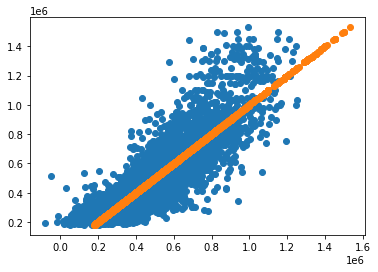

In [24]:
X2 = df2.drop(['price'], axis=1)
y2 = df2[['price']]
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2)
lr2 = LinearRegression()
lr2.fit(X2_train, y2_train)
y2_hat_train = lr2.predict(X2_train)
y2_hat_test = lr2.predict(X2_test)
train2_rmse = mse(y2_train, y2_hat_train, squared=False)
test2_rmse = mse(y2_test, y2_hat_test, squared=False)
condition_num2 = sm.OLS(y2_train, sm.add_constant(X2_train)).fit().condition_number
print('LR2 Train R\u00b2:', lr2.score(X2_train, y2_train))
print('LR2 Test R\u00b2:', lr2.score(X2_train, y2_train))
print('LR2 Train RMSE:', train2_rmse)
print('LR2 Test RMSE:', test2_rmse)
print('LR7 Condition Number:',condition_num2)
y2_test_pred = lr2.predict(X2_test)
plt.scatter(y2_test_pred, y2_test)
plt.scatter(y2_test, y2_test);

<b>Third Multiple Linear Regression Model</b>
\
Second model with log transformed price, sqft_living, and distance_from_bellevue, and other continuous variables.

In [25]:
df3 = df2.copy()
df3['price_log'] = np.log(df2['price'])
df3['sqft_living_log'] = np.log(df3['sqft_living'])
df3['distance_from_bellevue_log'] = np.log(df3['distance_from_bellevue'])
df3['sqft_lot_log'] = np.log(df2['sqft_lot'])
df3 = df3.drop(['price', 'sqft_living', 'distance_from_bellevue','sqft_lot'], axis=1)

LR3 Train R²: 0.7710735650508587
LR3 Test R²: 0.7664798818166713
LR3 Train RMSE: 0.21193655370980347
LR3 Test RMSE: 0.20882679492683884
LR3 Condition Number: 1.001320905302204e+16


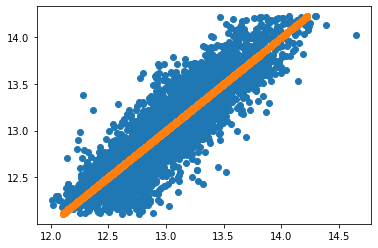

In [26]:
X3 = df3.drop(['price_log'], axis=1)
y3 = df3[['price_log']]
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3)
lr3 = LinearRegression()
lr3.fit(X3_train, y3_train)
y3_hat_train = lr3.predict(X3_train)
y3_hat_test = lr3.predict(X3_test)
train3_rmse = mse(y3_train, y3_hat_train, squared=False)
test3_rmse = mse(y3_test, y3_hat_test, squared=False)
condition_num3 = sm.OLS(y3_train, sm.add_constant(X3_train)).fit().condition_number
print('LR3 Train R\u00b2:', lr3.score(X3_train, y3_train))
print('LR3 Test R\u00b2:', lr3.score(X3_test, y3_test))
print('LR3 Train RMSE:', train3_rmse)
print('LR3 Test RMSE:', test3_rmse)
print('LR3 Condition Number:',condition_num3)
y3_test_pred = lr3.predict(X3_test)
plt.scatter(y3_test_pred, y3_test)
plt.scatter(y3_test, y3_test);

<b>Fourth Multiple Linear Regression Model</b>
\
Third model with multicollinear variables removed.

In [27]:
#Making a heat map to check for multicollinearity
corr = df3.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='mako', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

In [28]:
#Selecting which variables we feel comfortable moving forward with
df4 = df3[['price_log', 'sqft_living_log', 'distance_from_bellevue_log','sqft_lot_log',
          'waterfront', 'yr_renovated', 'house_age', 'view_none']]

In [29]:
corr = df4.corr()
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style
 .background_gradient(cmap='mako', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
 .set_precision(2))

LR4 Train R²: 0.588175511728797
LR4 Test R²: 0.5981068463670351
LR4 Train RMSE: 0.28170020490184783
LR4 Test RMSE: 0.2815580293362851
LR4 Condition Number: 9165.499808642742


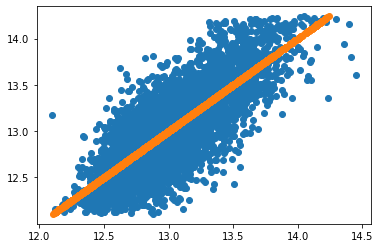

In [30]:
X4 = df4.drop(['price_log'], axis=1)
y4 = df4[['price_log']]
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4)
lr4 = LinearRegression()
lr4.fit(X4_train, y4_train)
y4_hat_train = lr4.predict(X4_train)
y4_hat_test = lr4.predict(X4_test)
train4_rmse = mse(y4_train, y4_hat_train, squared=False)
test4_rmse = mse(y4_test, y4_hat_test, squared=False)
condition_num4 = sm.OLS(y4_train, sm.add_constant(X4_train)).fit().condition_number

print('LR4 Train R\u00b2:', lr4.score(X4_train, y4_train))
print('LR4 Test R\u00b2:', lr4.score(X4_test, y4_test))
print('LR4 Train RMSE:', train4_rmse)
print('LR4 Test RMSE:', test4_rmse)
print('LR4 Condition Number:',condition_num4)

y4_test_pred = lr4.predict(X4_test)
plt.scatter(y4_test_pred, y4_test)
plt.scatter(y4_test, y4_test);

<b>Fifth Multiple Linear Regression Model</b>
\
Fourth model with several predictor variables scaled.

In [31]:
#Applying a standard scaler to our continuous variables
df5 = df4.copy()
col_names = ['sqft_living_log', 'distance_from_bellevue_log', 'sqft_lot_log',
            'yr_renovated','house_age']
features = df5[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
df5[col_names] = features

LR5 Train R²: 0.5879392642546251
LR5 Test R²: 0.5987762963115495
LR5 Train RMSE: 0.2825149340905738
LR5 Test RMSE: 0.27915393037643454
LR5 Condition Number: 24.921890162559567


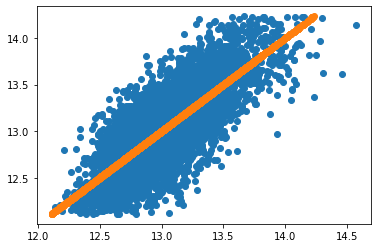

In [32]:
X5 = df5.drop(['price_log'], axis=1)
y5 = df5[['price_log']]
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5)
lr5 = LinearRegression()
lr5.fit(X5_train, y5_train)
y5_hat_train = lr5.predict(X5_train)
y5_hat_test = lr5.predict(X5_test)
train5_rmse = mse(y5_train, y5_hat_train, squared=False)
test5_rmse = mse(y5_test, y5_hat_test, squared=False)
condition_num5 = sm.OLS(y5_train, sm.add_constant(X5_train)).fit().condition_number
print('LR5 Train R\u00b2:', lr5.score(X5_train, y5_train))
print('LR5 Test R\u00b2:', lr5.score(X5_test, y5_test))
print('LR5 Train RMSE:', train5_rmse)
print('LR5 Test RMSE:', test5_rmse)
print('LR5 Condition Number:',condition_num5)
y5_test_pred = lr5.predict(X5_test)
plt.scatter(y5_test_pred, y5_test)
plt.scatter(y5_test, y5_test);

<b>Sixth Multiple Linear Regression Model</b>
\
Fifth model using recursive feature elimination.

In [33]:
#Using the recurcive feature eliminator to select variabels for our next model
selector = RFE(lr5, n_features_to_select=4)
selector = selector.fit(X5, y5)
print(selector.support_)
display(X5)

[ True  True False  True False False  True]


sqft_living_log  distance_from_bellevue_log  sqft_lot_log  waterfront  \
0            -1.315688                   -0.597021     -0.361090           0   
1             0.813688                    0.124814     -0.080384           0   
3             0.072443                    0.231388     -0.499291           0   
4            -0.349253                   -0.422152      0.043429           0   
6            -0.292847                    1.503457     -0.148440           0   
...                ...                         ...           ...         ...   
21592        -0.605104                    0.055117     -2.180001           0   
21593         0.521912                    0.091045     -0.328929           0   
21594        -1.714298                   -1.307050     -1.979851           0   
21595        -0.482724                   -0.343840     -1.334912           0   
21596        -1.714298                   -1.306193     -2.236372           0   

       yr_renovated  house_age  view_none  
0         -0.184258   0.561359        1.0  
1          5.412837   0.698607        1.0  
3         -0.184258   0.218238        1.0  
4         -0.184258  -0.502317        1.0  
6         -0.184258  -0.811126        1.0  
...             ...        ...        ...  
21592     -0.184258  -1.291496        1.0  
21593     -0.184258  -1.428745        1.0  
21594     -0.184258  -1.291496        1.0  
21595     -0.184258  -1.085623        1.0  
21596     -0.184258  -1.257184        1.0  

[19733 rows x 7 columns]

> Selector selects sqft_living_log, distance_from_bellevue_log, waterfront, & view_none.

LR6 Train R²: 0.5854459587429532
LR6 Test R²: 0.5858729777718898
LR6 Train RMSE: 0.28363978204734774
LR6 Test RMSE: 0.28282305780280415
LR6 Condition Number: 24.091127817685116


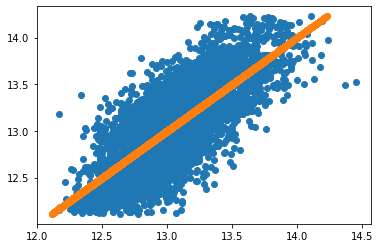

In [34]:
df6 = df5.copy()
X6 = df6[['sqft_living_log', 'distance_from_bellevue_log', 'waterfront', 'view_none']]
y6 = df6[['price_log']]
X6_train, X6_test, y6_train, y6_test = train_test_split(X6, y6)
lr6 = LinearRegression()
lr6.fit(X6_train, y6_train)
y6_hat_train = lr6.predict(X6_train)
y6_hat_test = lr6.predict(X6_test)
train6_rmse = mse(y6_train, y6_hat_train, squared=False)
test6_rmse = mse(y6_test, y6_hat_test, squared=False)
condition_num6 = sm.OLS(y6_train, sm.add_constant(X6_train)).fit().condition_number
print('LR6 Train R\u00b2:', lr6.score(X6_train, y6_train))
print('LR6 Test R\u00b2:', lr6.score(X6_test, y6_test))
print('LR6 Train RMSE:', train6_rmse)
print('LR6 Test RMSE:', test6_rmse)
print('LR6 Condition Number:',condition_num6)
y6_test_pred = lr6.predict(X6_test)
plt.scatter(y6_test_pred, y6_test)
plt.scatter(y6_test, y6_test);

<b>Seventh Multiple Linear Regression Model</b>
\
Sixth model using stepwise selection to choose significant features.

In [35]:
#Performing stepwise selection to determine what variables have a significant relationship with the target variable
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

result = stepwise_selection(X5, y5, verbose=True)
print('resulting features:')
print(result)

Add distance_from_bellevue_log     with p-value 0.0
Add view_none                      with p-value 0.0
Add sqft_living_log                with p-value 0.0
Add house_age                      with p-value 1.9158e-40
Add waterfront                     with p-value 8.52867e-30
Add yr_renovated                   with p-value 4.12047e-11
Add sqft_lot_log                   with p-value 6.57435e-09
resulting features:
['distance_from_bellevue_log', 'view_none', 'sqft_living_log', 'house_age', 'waterfront', 'yr_renovated', 'sqft_lot_log']


> Stepwise Selection has determined all of our variables have a p-values less than an alpha of .05

LR7 Train R²: 0.5903916264446546
LR7 Test R²: 0.5916737150909092
LR7 Train RMSE: 0.2817047366292947
LR7 Test RMSE: 0.281559353755675
LR7 Condition Number: 23.730072313671045


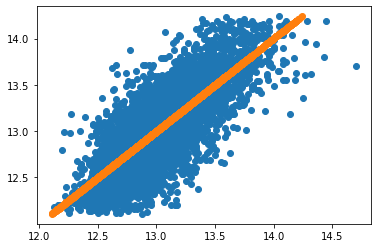

In [36]:
df7 = df6.copy()
X7 = df7[['distance_from_bellevue_log', 'view_none', 'sqft_living_log', 'house_age', 'waterfront', 'yr_renovated', 'sqft_lot_log']]
y7 = df7[['price_log']]
X7_train, X7_test, y7_train, y7_test = train_test_split(X7, y7)
lr7 = LinearRegression()
lr7.fit(X7_train, y7_train)
y7_hat_train = lr7.predict(X7_train)
y7_hat_test = lr7.predict(X7_test)
train7_rmse = mse(y7_train, y7_hat_train, squared=False)
test7_rmse = mse(y7_test, y7_hat_test, squared=False)
condition_num7 = sm.OLS(y7_train, sm.add_constant(X7_train)).fit().condition_number
print('LR7 Train R\u00b2:', lr7.score(X7_train, y7_train))
print('LR7 Test R\u00b2:', lr7.score(X7_test, y7_test))
print('LR7 Train RMSE:', train7_rmse)
print('LR7 Test RMSE:', test7_rmse)
print('LR7 Condition Number:',condition_num7)
y7_test_pred = lr7.predict(X7_test)
plt.scatter(y7_test_pred, y7_test)
plt.scatter(y7_test, y7_test);

## Conclusions

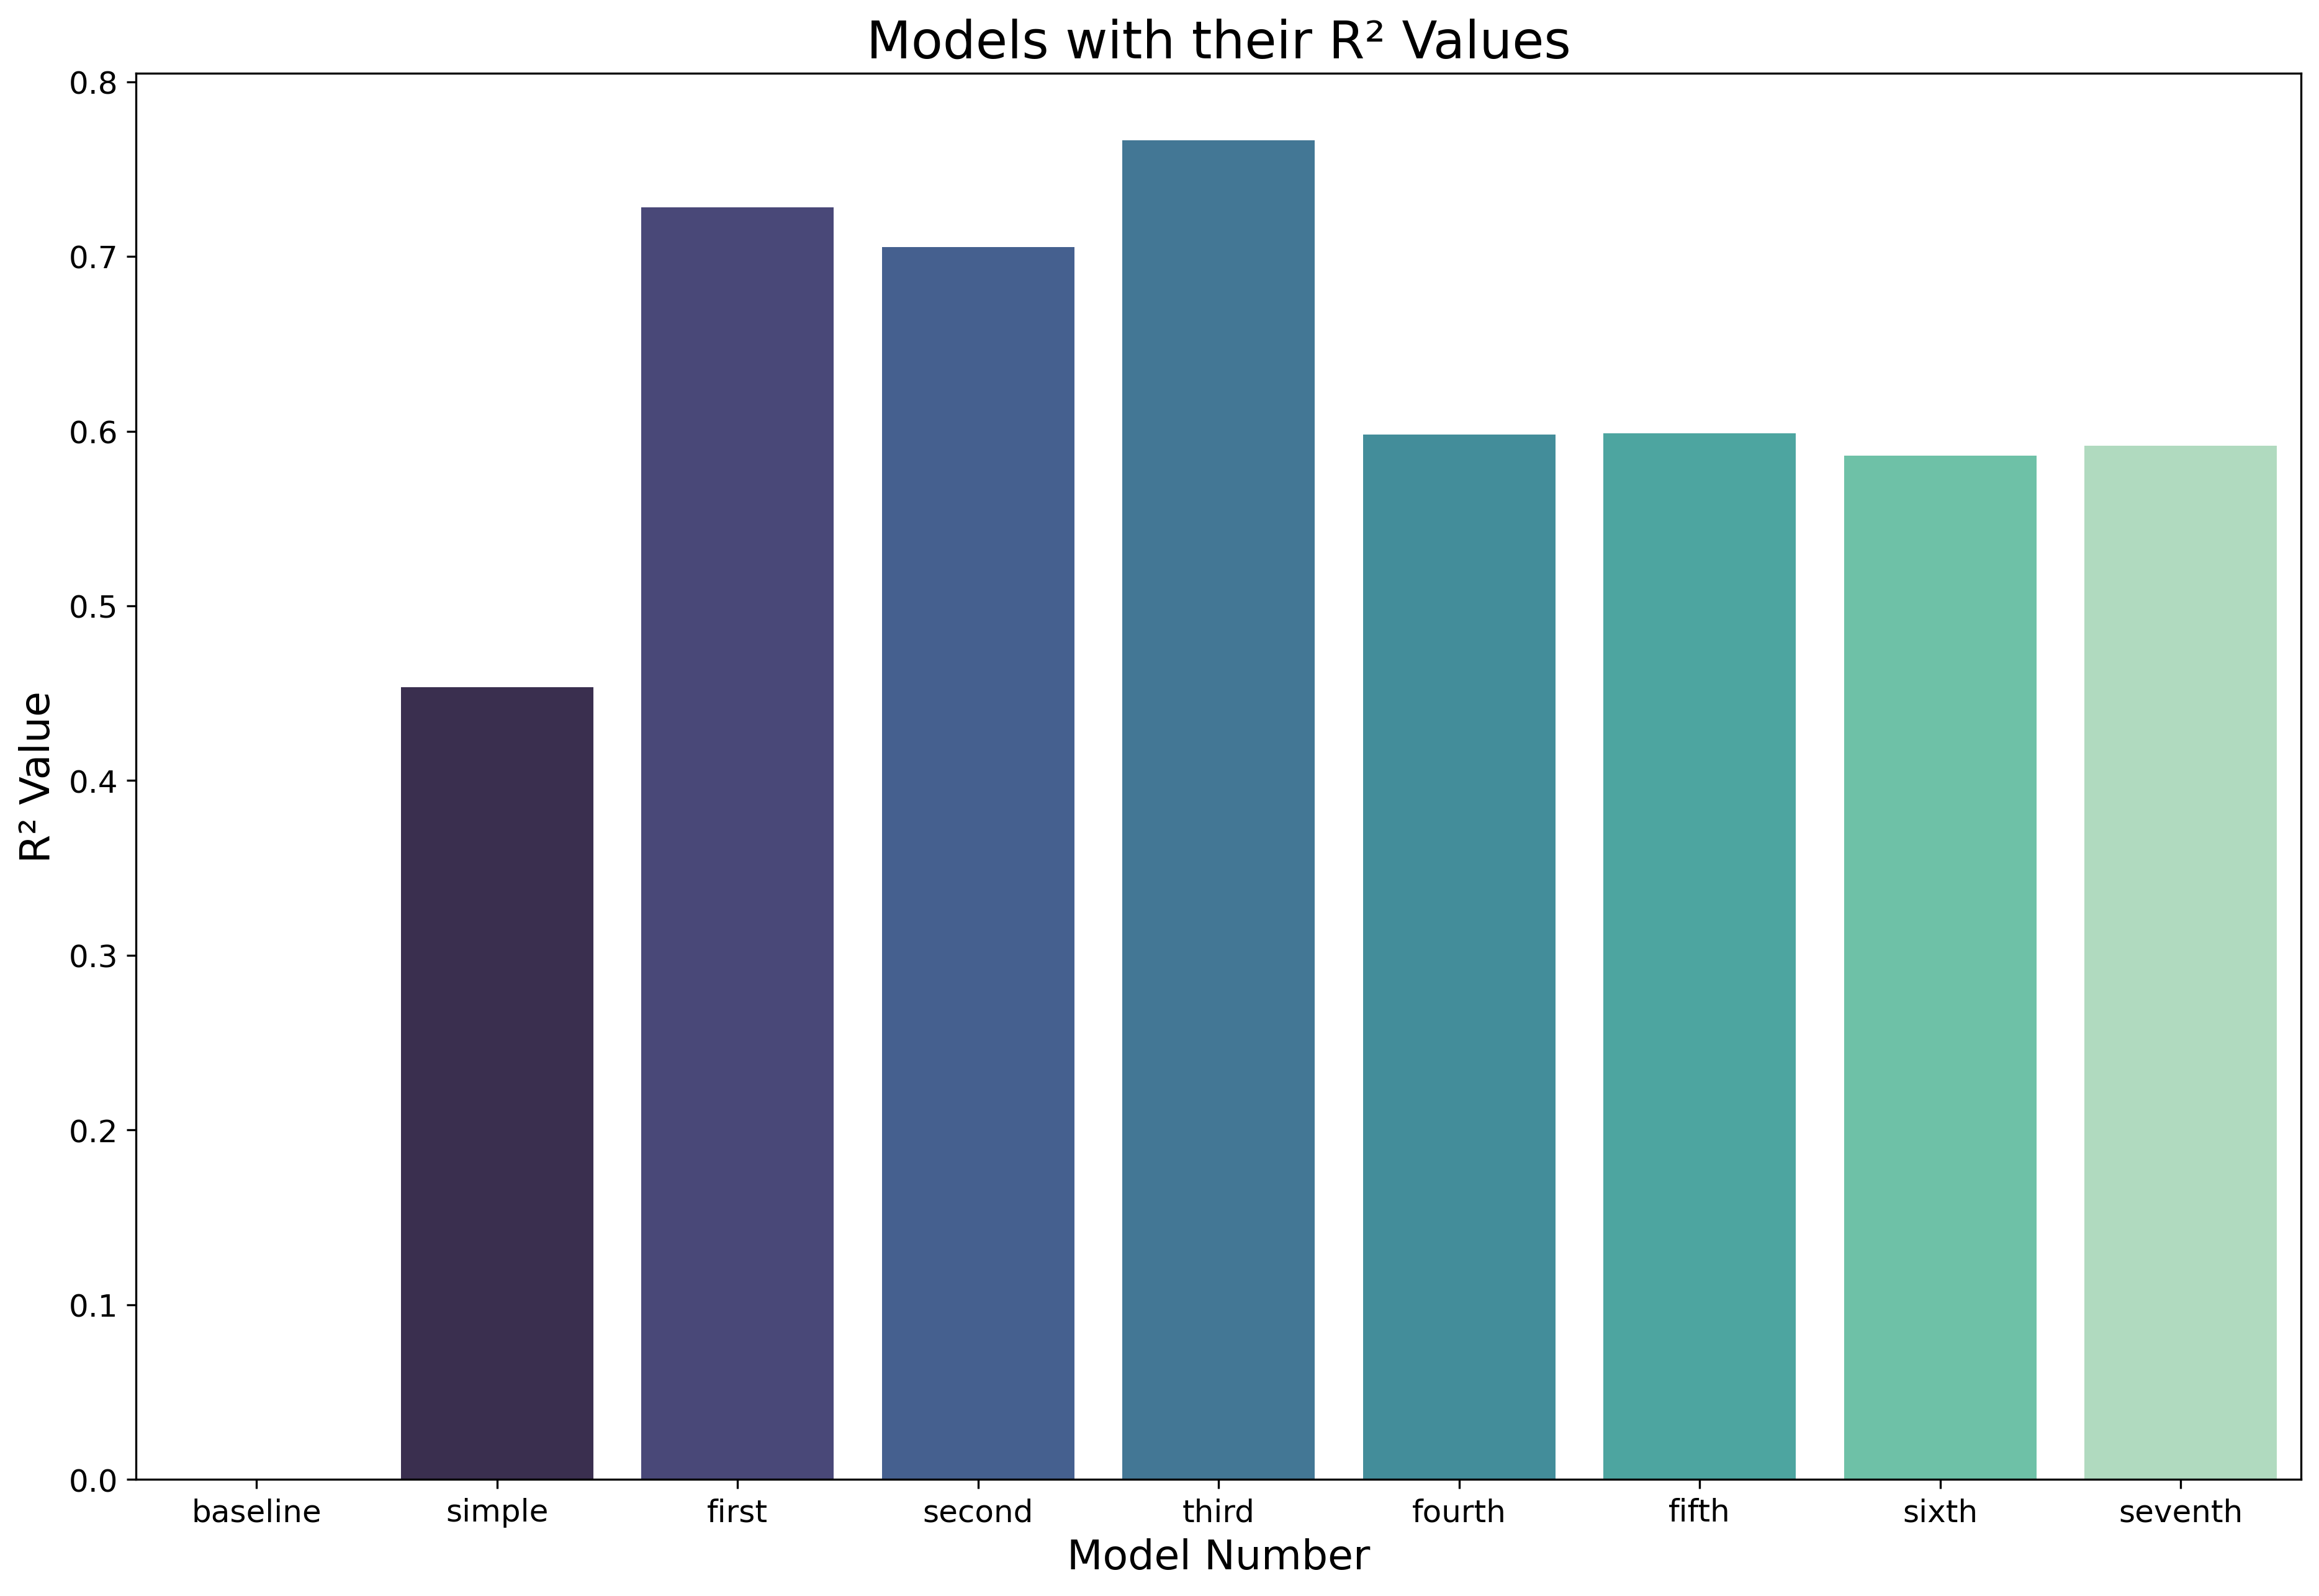

In [37]:
baseline = baseline.score(X_test, y_test)
simple = lr.score(X_test, y_test)
first = lr1.score(X1_test, y1_test)
second = lr2.score(X2_test, y2_test)
third = lr3.score(X3_test, y3_test)
fourth = lr4.score(X4_test, y4_test)
fifth = lr5.score(X5_test, y5_test)
sixth = lr6.score(X6_test, y6_test)
seventh = lr7.score(X7_test, y7_test)

barchart = pd.DataFrame({'Model':['baseline', 'simple', 'first', 'second',
                                  'third', 'fourth', 'fifth', 'sixth', 'seventh'],
                         'R\u00b2':[baseline, simple, first, second, third, fourth, fifth, sixth, seventh]})
plt.figure(figsize=(15,10), dpi=300)
ax = sns.barplot(x=barchart['Model'], y=barchart['R\u00b2'], palette="mako")
plt.title("Models with their R\u00b2 Values", fontsize=20)
ax.set_xlabel('Model Number', fontsize=16)
ax.set_ylabel('R\u00b2 Value', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

In [39]:
plotdf = pd.DataFrame({'Predictor':['distance_from_bellevue_log', 'view_none', 'sqft_living_log', 'house_age', 'waterfront', 'yr_renovated', 'sqft_lot_log'],
                       'Coefficient':[-0.19245633, -0.19812453,  0.25314856,  0.03020422,  0.38718511,
         0.01240198, -0.01416162]})
plotdf = plotdf.sort_values(by=['Coefficient'])

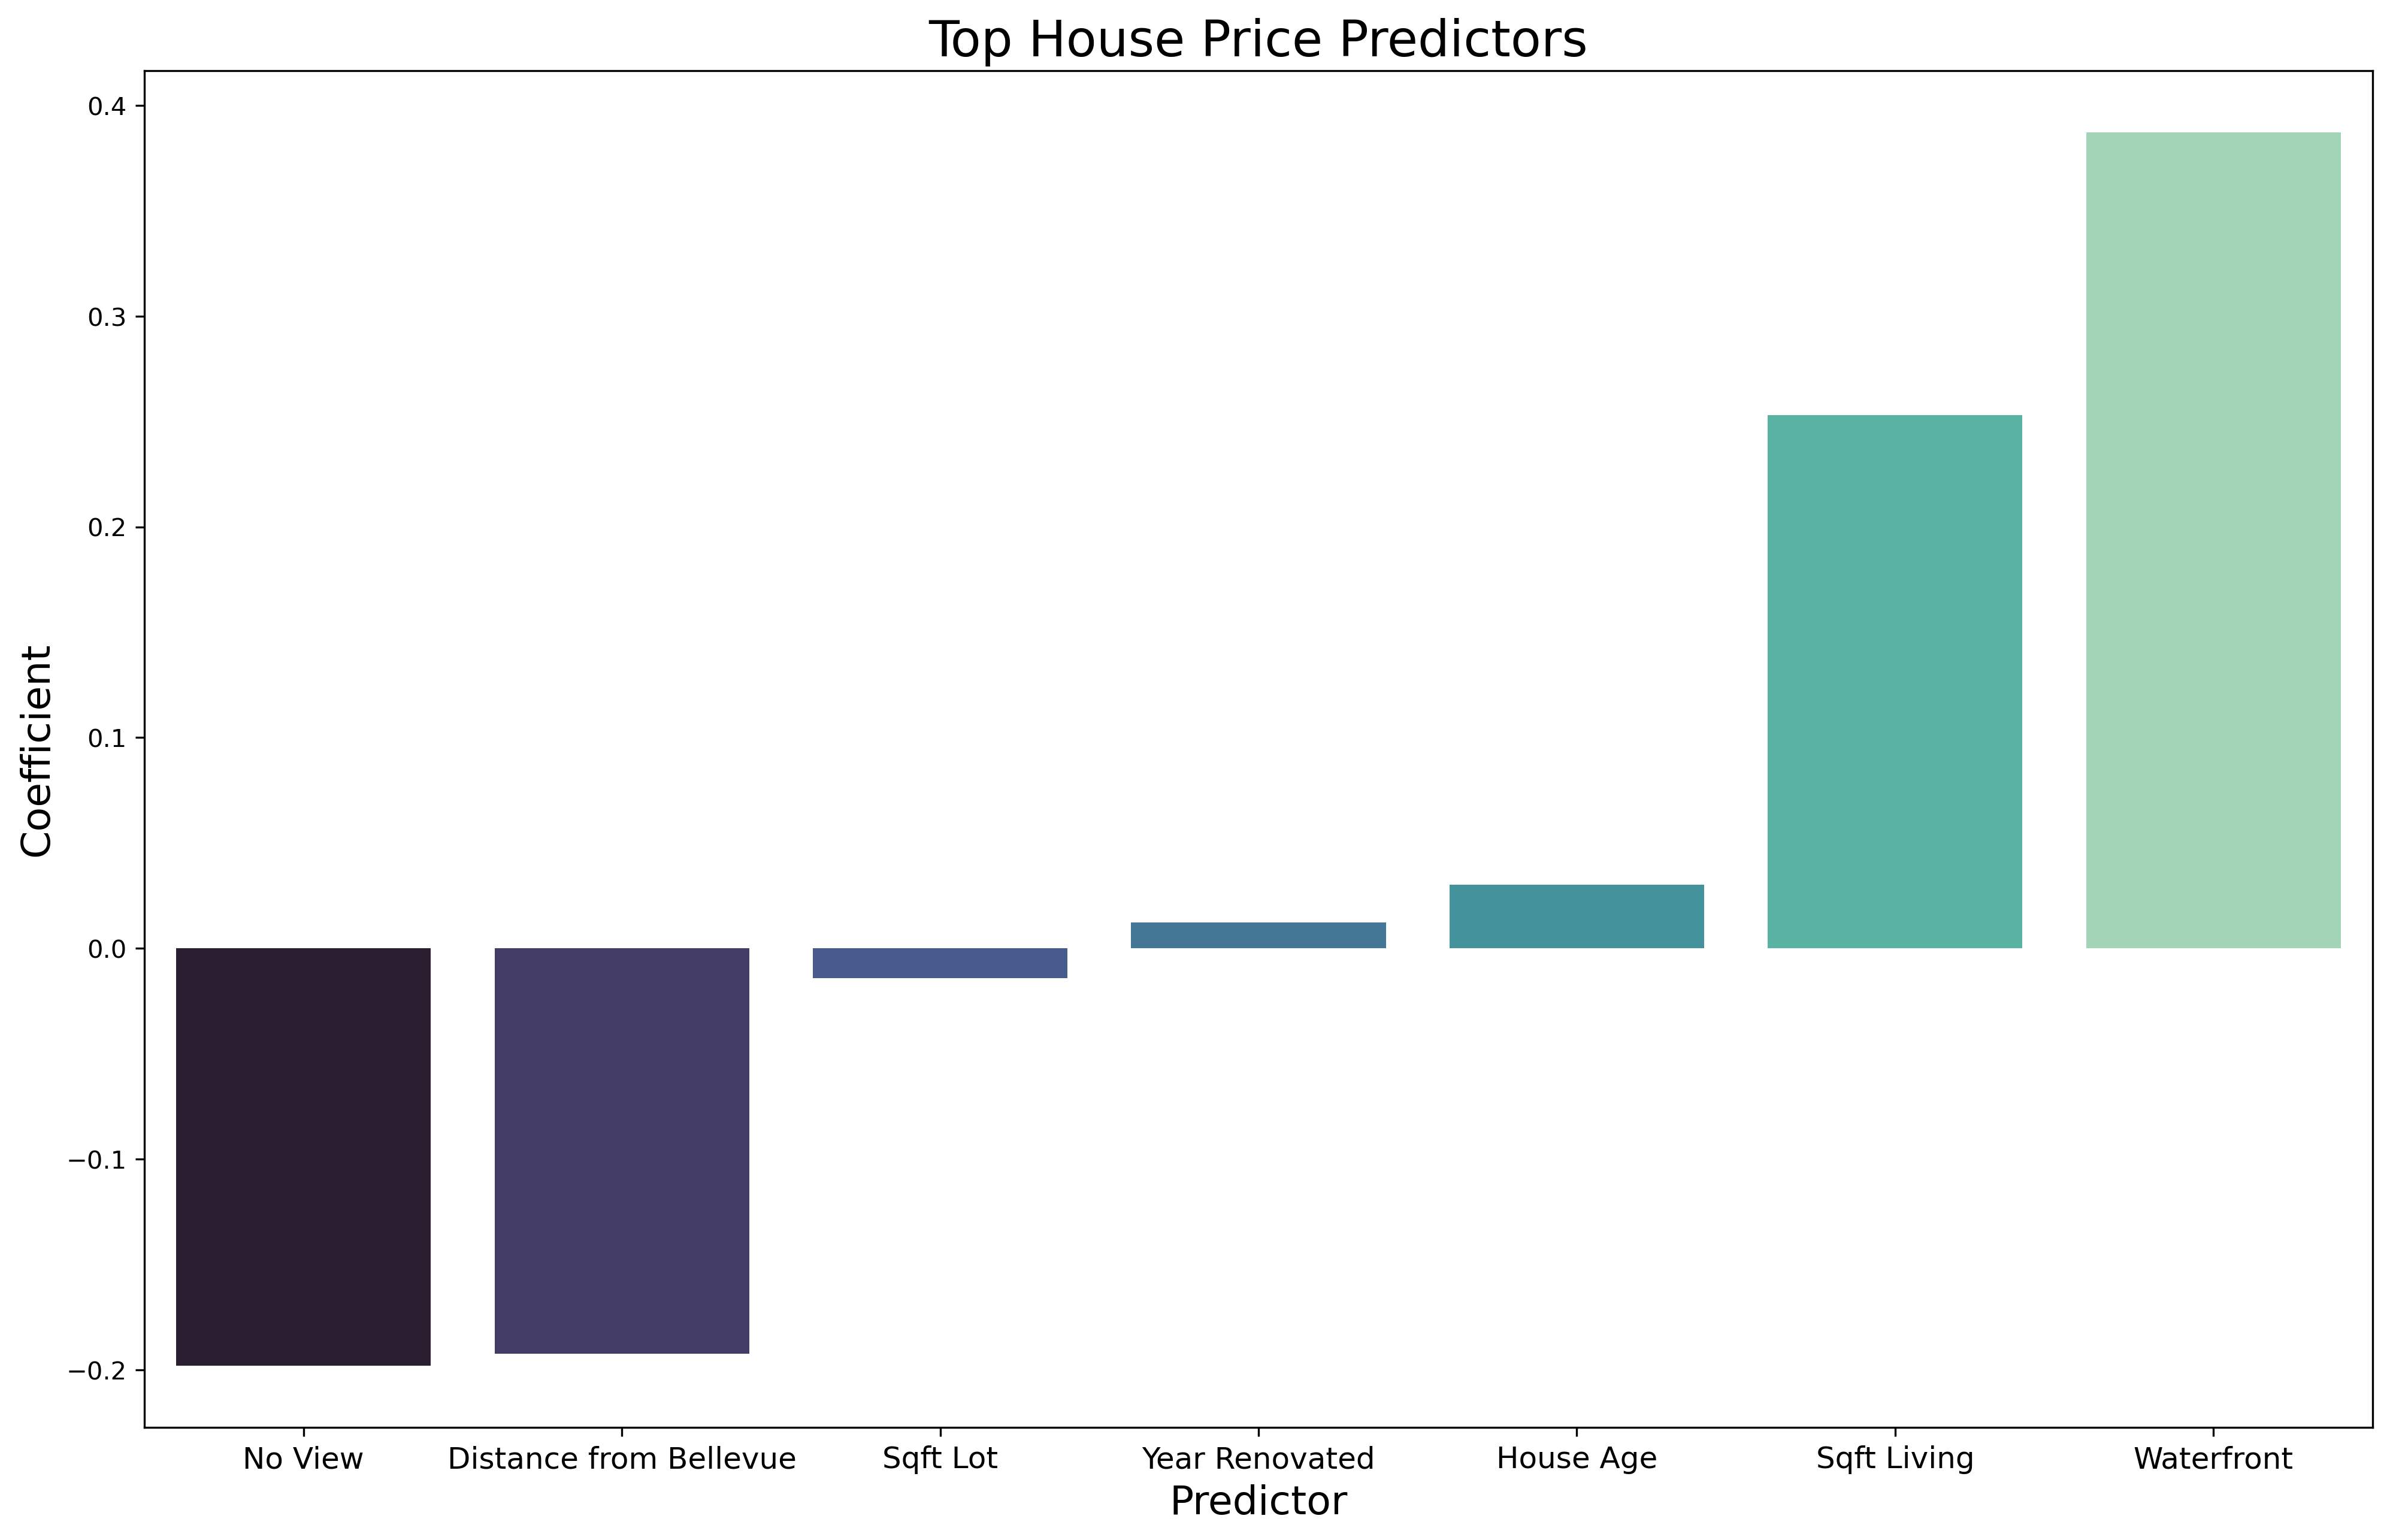

In [41]:
fig, ax = plt.subplots(figsize=(16,10), dpi=300)
ax = sns.barplot(x=plotdf['Predictor'], y=plotdf['Coefficient'], palette="mako",)
ax.set_title('Top House Price Predictors', fontsize=20)
ax.set_xlabel('Predictor', fontsize=16)
ax.set_ylabel('Coefficient', fontsize=16)
labels = ['No View', 'Distance from Bellevue', 'Sqft Lot', 'Year Renovated', 'House Age', 'Sqft Living', 'Waterfront']
ax.set_xticklabels(labels, fontsize=12);